<a href="https://colab.research.google.com/github/danplotkin/LSTM_Time_Series/blob/main/TimeSeriesLSTM_bidirectional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [ ]:
import os
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from google.colab import drive
import matplotlib.pyplot as plt
import io
import copy
from sklearn.metrics import mean_squared_error
drive.mount('/content/drive')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (10, 6)

Mounted at /content/drive


In [ ]:
torch.manual_seed(42)

# Load Data

In [ ]:
# Define the ticker symbol
ticker = "MSFT"

# Set the start and end dates for the data
start_date = "2000-01-01"
end_date = "2023-04-30"

# Download the data from Yahoo Finance
data = yf.download(ticker, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [ ]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,58.68750,59.3125,56.00000,58.28125,36.205593,53228400
2000-01-04,56.78125,58.5625,56.12500,56.31250,34.982574,54119000
2000-01-05,55.56250,58.1875,54.68750,56.90625,35.351414,64059600
2000-01-06,56.09375,56.9375,54.18750,55.00000,34.167225,54976600
2000-01-07,54.31250,56.1250,53.65625,55.71875,34.613731,62013600


In [ ]:
df = data.drop(labels=['Open', 'High', 'Low', 'Close', 'Volume'], axis=1)
df.head()

,Adj Close
Date,
2000-01-03,36.205593
2000-01-04,34.982574
2000-01-05,35.351414
2000-01-06,34.167225
2000-01-07,34.613731


# Plot Adj Closing Price Over Time

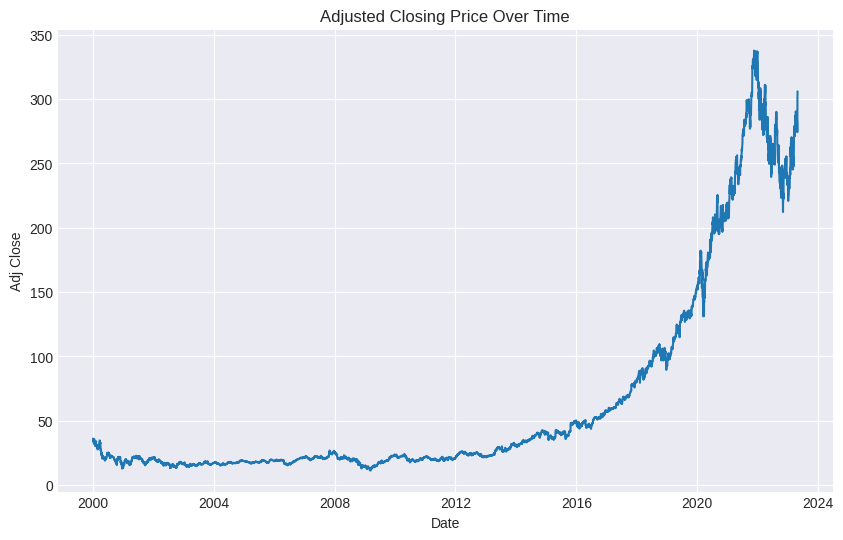

In [ ]:
plt.plot(df.index, df['Adj Close'])
plt.title('Adjusted Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.show()

# Prepare Data

In [ ]:
def prepare_df(df, window_size):
    df = df.copy()

    for i in range(1, window_size + 1):
        df[f'Adj Close(t-{i})'] = df['Adj Close'].shift(i)

    return df.dropna()

In [ ]:
window_size = 5
dataset = prepare_df(df, window_size=window_size)
X = dataset.iloc[:, 1:window_size+1].iloc[:, ::-1]
y = dataset.iloc[:, window_size+1:]
dataset = pd.concat([X, dataset.iloc[:, 0], y], axis=1)
dataset.head()

,Adj Close(t-5),Adj Close(t-4),Adj Close(t-3),Adj Close(t-2),Adj Close(t-1),Adj Close
Date,,,,,,
2000-01-10,36.205593,34.982574,35.351414,34.167225,34.613731,34.866089
2000-01-11,34.982574,35.351414,34.167225,34.613731,34.866089,33.973087
2000-01-12,35.351414,34.167225,34.613731,34.866089,33.973087,32.866520
2000-01-13,34.167225,34.613731,34.866089,33.973087,32.866520,33.487755
2000-01-14,34.613731,34.866089,33.973087,32.866520,33.487755,34.866089


In [ ]:
train, val = train_test_split(dataset, test_size=0.1, shuffle=False) # do not shuffle

In [ ]:
scaler = MinMaxScaler().fit(train) # fit scaler

### Create a PyTorch Dataset

In [ ]:
class MicrosoftDataset(Dataset):
    def __init__(self, dataset, scaler):
        dataset = scaler.transform(dataset)
        X, y = dataset[:, :window_size], dataset[:, window_size:]
        self.X = torch.tensor(np.expand_dims(X, axis=-1)).float()
        self.y = torch.tensor(y).float()

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [ ]:
# load in datasets
train_ds = MicrosoftDataset(train, scaler)
val_ds = MicrosoftDataset(val, scaler)

# batch into dataloaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)

In [ ]:
print(f'Train Loader Size: {len(train_loader)} \nValid Loader Size: {len(val_loader)}')

Train Loader Size: 165 
Valid Loader Size: 19


In [ ]:
for ex_in, ex_out in train_loader:
    print(ex_in.shape, ex_out.shape)
    break

torch.Size([32, 5, 1]) torch.Size([32, 1])


# Define Model

In [ ]:
INPUT_SIZE = 1
HIDDEN_SIZE = 64
OUTPUT_SIZE = 1
NUM_LAYERS = 2
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size*2, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(DEVICE)
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(DEVICE)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Create Early Stopper

In [ ]:
class EarlyStopping:
    """
    Early stopping utility for monitoring validation loss during training.

    Args:
        patience (int): Number of epochs with no improvement after which training will be stopped.
        min_delta (float): Minimum change in the monitored quantity to qualify as an improvement.
        restore_best_weights (bool): Whether to restore the model to the best state when stopping.

    Attributes:
        patience (int): Number of epochs with no improvement after which training will be stopped.
        min_delta (float): Minimum change in the monitored quantity to qualify as an improvement.
        restore_best_weights (bool): Whether to restore the model to the best state when stopping.
        best_model: Copy of the model with the best validation loss.
        best_loss (float): Best validation loss observed so far.
        counter (int): Counter for the number of epochs with no improvement.
        status (str): Current status message indicating the early stopping progress.
    """

    def __init__(self, patience=5, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_model = None
        self.best_loss = None
        self.counter = 0
        self.status = ""

    def __call__(self, model, val_loss):
        """
        Check whether to stop training based on the validation loss.

        Args:
            model: The deep learning model being monitored.
            val_loss (float): Current validation loss.

        Returns:
            bool: True if training should be stopped, False otherwise.
        """
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model)
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model.load_state_dict(model.state_dict())
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.status = f"Stopped on {self.counter}"
                if self.restore_best_weights:
                    model.load_state_dict(self.best_model.state_dict())
                return True
        self.status = f"{self.counter}/{self.patience}"
        return False

# Create Trainer

In [ ]:
class Trainer:
    """
    A class for training and evaluating a deep learning model.

    Args:
        train_loader (torch.utils.data.DataLoader): DataLoader for the training dataset.
        val_loader (torch.utils.data.DataLoader): DataLoader for the validation dataset.
        criterion: Loss criterion for training.
        optimizer: Optimizer for updating model parameters.
        model: The deep learning model to train and evaluate.
        device: Device on which to perform computations (e.g., 'cuda' or 'cpu').
        max_epochs (int): Maximum number of training epochs.

    Attributes:
        train_loader (torch.utils.data.DataLoader): DataLoader for the training dataset.
        val_loader (torch.utils.data.DataLoader): DataLoader for the validation dataset.
        criterion: Loss criterion for training.
        optimizer: Optimizer for updating model parameters.
        model: The deep learning model being trained and evaluated.
        device: Device on which computations are performed.
        early_stopper: Early stopping utility to monitor validation loss.
        max_epochs (int): Maximum number of training epochs.
        history (dict): Training and validation loss history.
        output_dir (str): Directory to save trained models.
        scheduler: Learning rate scheduler based on validation loss.
    """

    def __init__(self,
                 train_loader,
                 val_loader,
                 criterion,
                 optimizer,
                 model,
                 device,
                 max_epochs):
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.criterion = criterion
        self.optimizer = optimizer
        self.model = model
        self.device = device
        self.early_stopper = EarlyStopping(patience=10)
        self.max_epochs = max_epochs
        self.history = {}
        self.output_dir = '/content/drive/MyDrive/Models/TimeSeriesLSTM'
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

    def _train_epoch(self):
        """
        Perform a single training epoch.

        Returns:
            float: Average training loss for the epoch.
        """
        self.model.train()
        running_loss = 0.00
        for batch_idx, (input, truth) in enumerate(self.train_loader):
            input, truth = input.to(self.device), truth.to(self.device)
            self.optimizer.zero_grad()
            pred = self.model(input)
            loss = self.criterion(pred, truth)
            loss.backward()
            self.optimizer.step()
            running_loss += loss.item()

        return running_loss / len(self.train_loader)

    @torch.no_grad()
    def _eval_epoch(self):
        """
        Perform a single evaluation epoch.

        Returns:
            float: Average validation loss for the epoch.
        """
        self.model.eval()
        running_loss = 0.00
        for batch_idx, (input, truth) in enumerate(self.val_loader):
            input, truth = input.to(self.device), truth.to(self.device)
            pred = self.model(input)
            loss = self.criterion(pred, truth)
            running_loss += loss.item()
        return running_loss / len(self.val_loader)

    def train(self):
        """
        Train the model using the provided training and validation data.

        This method trains the model for the specified number of epochs,
        monitoring training and validation loss, applying early stopping,
        and adjusting the learning rate using a scheduler.
        """
        best_val_loss = np.inf
        best_epoch = 0

        train_losses, val_losses = [], []
        for epoch in range(self.max_epochs):
            print(f'Epoch {epoch+1}/{self.max_epochs}:')

            tloss = self._train_epoch()
            train_losses.append(tloss)
            print(f'Train loss: {tloss:.4f}')

            vloss = self._eval_epoch()
            val_losses.append(vloss)
            print(f'Val loss: {vloss:.4f}')

            self.scheduler.step(vloss)

            if vloss < best_val_loss:
                best_val_loss = vloss
                best_epoch = epoch + 1

            if self.early_stopper(self.model, vloss):
                print(f'best epoch: {best_epoch}')
                break

            print()

        print('Training Finished')
        torch.save(self.model, self.output_dir)

        self.history = {'train': train_losses, 'val': val_losses}

    def evaluate(self):
        """
        Evaluate the trained model on the validation dataset.

        Returns:
            float: Rounded validation loss.
        """
        vloss = self._eval_epoch()
        return np.round(vloss, 4)

# Train Model

In [ ]:
model = LSTM(
    INPUT_SIZE,
    HIDDEN_SIZE,
    OUTPUT_SIZE,
    NUM_LAYERS
).to(DEVICE)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-6, weight_decay=0.01)

In [ ]:
with torch.no_grad():
    print(model(ex_in).shape)

torch.Size([32, 1])


In [ ]:
trainer = Trainer(
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    model=model,
    device=DEVICE,
    max_epochs=250
)

trainer.train()

Epoch 1/250:
Train loss: 0.0411
Val loss: 1.1715

Epoch 2/250:
Train loss: 0.0406
Val loss: 1.1570

Epoch 3/250:
Train loss: 0.0402
Val loss: 1.1435

Epoch 4/250:
Train loss: 0.0399
Val loss: 1.1315

Epoch 5/250:
Train loss: 0.0395
Val loss: 1.1194

Epoch 6/250:
Train loss: 0.0393
Val loss: 1.1089

Epoch 7/250:
Train loss: 0.0390
Val loss: 1.0986

Epoch 8/250:
Train loss: 0.0387
Val loss: 1.0884

Epoch 9/250:
Train loss: 0.0385
Val loss: 1.0788

Epoch 10/250:
Train loss: 0.0382
Val loss: 1.0698

Epoch 11/250:
Train loss: 0.0380
Val loss: 1.0609

Epoch 12/250:
Train loss: 0.0377
Val loss: 1.0522

Epoch 13/250:
Train loss: 0.0374
Val loss: 1.0434

Epoch 14/250:
Train loss: 0.0372
Val loss: 1.0346

Epoch 15/250:
Train loss: 0.0369
Val loss: 1.0262

Epoch 16/250:
Train loss: 0.0366
Val loss: 1.0169

Epoch 17/250:
Train loss: 0.0363
Val loss: 1.0085

Epoch 18/250:
Train loss: 0.0361
Val loss: 0.9996

Epoch 19/250:
Train loss: 0.0358
Val loss: 0.9904

Epoch 20/250:
Train loss: 0.0355
Val los

In [ ]:
trainer.evaluate()

0.001

In [ ]:
lstm_model = torch.load('/content/drive/MyDrive/Models/TimeSeriesLSTM').to(DEVICE)

# Visualize Forecast on Testing Data

We will create a class to visualize and evaluate predictions.

In [ ]:
class TimeSeriesForecast:
    """
    Class for making time series predictions using an LSTM model and visualizing the results.

    Args:
        lstm_model: Trained LSTM model for making predictions.
        device: Device on which to perform computations (e.g., 'cuda' or 'cpu').
        scaler: Scaler used to normalize and denormalize data.
        val_data: Validation data used for making predictions.

    Attributes:
        model: Trained LSTM model for making predictions.
        device: Device on which computations are performed.
        scaler: Scaler used to normalize and denormalize data.
        val_data: Validation data used for making predictions.
    """

    def __init__(self, lstm_model, device, scaler, val_data):
        self.model = lstm_model
        self.device = device
        self.scaler = scaler
        self.val_data = val_data

    @torch.no_grad()
    def _predict(self, idx):
        """
        Make predictions for a specific data point.

        Args:
            idx (int): Index of the data point in the validation data.

        Returns:
            tuple: Tuple containing the input sequence, ground truth, and predictions.
        """
        self.model.eval()
        X, y = self.val_data.__getitem__(idx)
        X = X.unsqueeze(0).to(self.device)
        preds = self.model(X)
        return X.flatten(), y, preds.flatten(),

    def _get_unormalized(self, idx):
        """
        Get unnormalized values for a specific data point.

        Args:
            idx (int): Index of the data point in the validation data.

        Returns:
            tuple: Tuple containing the unnormalized ground truth and predictions.
        """
        X, truth, preds = self._predict(idx)
        truth_row = torch.cat([X, truth])
        truth_row = truth_row.detach().numpy().reshape(1, -1)
        preds_row = torch.cat([X, preds])
        preds_row = preds_row.detach().numpy().reshape(1, -1)
        return self.scaler.inverse_transform(truth_row), self.scaler.inverse_transform(preds_row)

    def get_predictions(self):
        """
        Get unnormalized ground truth and prediction values for the entire validation dataset.

        Returns:
            tuple: Tuple containing the unnormalized ground truth and predictions.
        """
        truth, preds = [], []
        for i, (input, output) in enumerate(self.val_data):
            truth_row, preds_row = self._get_unormalized(i)
            truth.extend(truth_row.flatten()[window_size:])
            preds.extend(preds_row.flatten()[window_size:])

        return truth, preds

    def plot(self):
        """
        Plot the ground truth and predicted values.

        This method creates a plot to visualize the ground truth and predicted values
        for the adjusted closing prices of a time series.
        """
        truth, preds = self.get_predictions()
        plt.plot(truth, label='Adj Close')
        plt.plot(preds, label='Pred Adj Close')
        plt.legend()
        plt.title('Microsoft Adjusted Closing Price Forecast')
        plt.xlabel('Day')
        plt.ylabel('Adj Close')
        plt.show()

    def rmse(self):
        """
        Calculate the Root Mean Squared Error (RMSE) between ground truth and predicted values.

        Returns:
            float: Root Mean Squared Error (RMSE).
        """
        truth, preds = self.get_predictions()
        mse = mean_squared_error(truth, preds)
        return np.sqrt(mse)

In [ ]:
ts = TimeSeriesForecast(lstm_model, DEVICE, scaler, val_ds)

### Plot Forecast

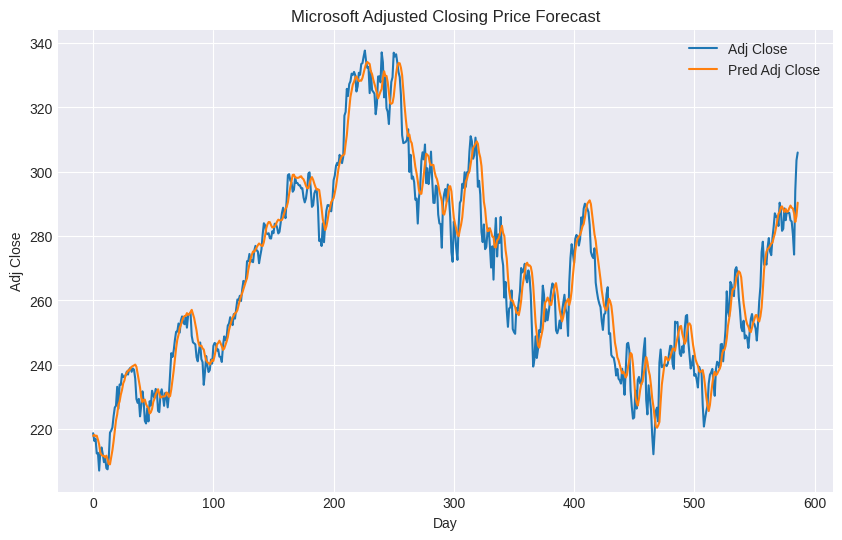

In [ ]:
ts.plot()

### Print RMSE

In [ ]:
print(f'Validation Root Mean Squared Error: {ts.rmse():.4f}')

Validation Root Mean Squared Error: 6.8416


This means that for every prediction step, the model on average is $6.84 off the actual adjusted closing price.